Instalación

In [2]:
!pip install git+https://github.com/huggingface/transformers
!pip install qwen-vl-utils
!pip install openai
!pip install flash-attn

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-5xpv8c74
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-5xpv8c74
  Resolved https://github.com/huggingface/transformers to commit 6daa3eeba582facb57cd71db8efb66998b12942f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
import torch
if torch.cuda.is_available():
    print("GPU está disponible:", torch.cuda.get_device_name(0))
else:
    print("GPU NO está disponible.")

GPU está disponible: Tesla T4


Descargar una imagen

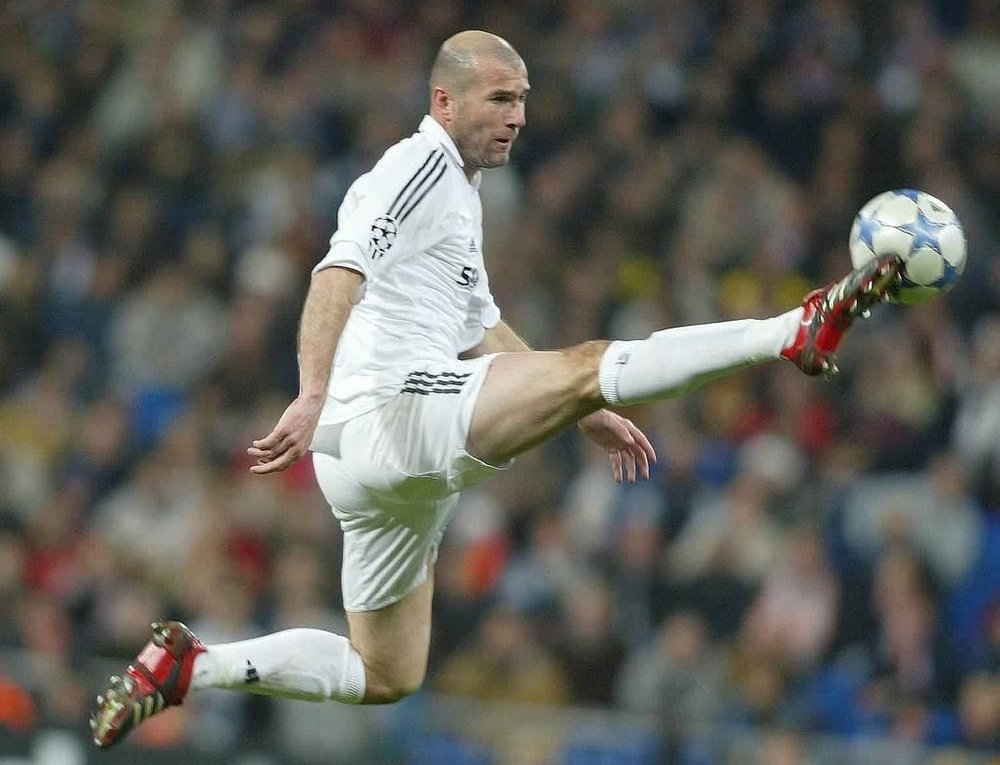

In [23]:
!pip install wget
import wget
from PIL import Image

url = "https://cdn.resfu.com/media/img_news/zinedine-zidane--en-un-partido-de-champions-league-con-el-real-madrid.jpg?size=1000x&lossy=1"
img = wget.download(url)
imagen = Image.open(img)


# Show the image
from IPython.display import Image
Image(filename=img)



In [8]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
checkpoint = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(checkpoint, torch_dtype=torch.bfloat16, device_map="auto")#, attn_implementation="flash_attention_2") #attn_implementation="flash_attention_2"
processor = AutoProcessor.from_pretrained(checkpoint)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
import base64



def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

prompt = 'Describe the given image', # Ajustar el prompt a las necesidades


In [24]:
messages=[
          {
          "role": "system",
          "content": [{"type":"text","text": "You are a helpful assistant."}]
          },

          {
          "role": "user",
          "content": [
              {
                  "type": "image_url",
                  "image_url": {"url": f"data:image/jpeg;base64,{encode_image(img)}"},
              },
              {"type": "text", "text": prompt},
          ],
          }
  ]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)



inputs = processor(text=[text], images = [imagen],  padding=True, return_tensors="pt")
inputs = inputs.to('cuda')

output_ids = model.generate(**inputs, max_new_tokens=4096)
generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

print(output_text[0])


The image shows a soccer player in action, wearing a white uniform with black stripes on the shoulders and shorts. The player is mid-air, performing an acrobatic kick with one leg extended towards a soccer ball. The ball is positioned near the player's foot, indicating a powerful and precise movement. The background is blurred, suggesting a stadium filled with spectators, which adds to the dynamic and intense atmosphere of the scene. The player's focused expression and the motion blur convey the speed and skill involved in the play.
